In [1]:
# Imports and plotting setups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math

import math_funcs

from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
    #e,           # Elementary charge
    #h,           # Planck constant
    #hbar,        # Reduced Planck constant (h-bar)
    k,           # Boltzmann constant
    #G,           # Newtonian constant of gravitation
    #m_e,         # Electron mass
    #m_p,         # Proton mass
    #m_n,         # Neutron mass
    #alpha,       # Fine-structure constant
    eV,          # Electron volt
)

from transmission_reflection_coefficients import transmissivity_fBm, reflectivity_fBm
from T_B_Europan_sky import angle_grid

In [11]:
# Magic number constants
# Low band
f = 5.373e6
epsilon_i_prime = 1
epsilon_t_prime = 2.76
H = 0.75
sigma_ref = 0.2
sigma = sigma_ref * (c/f)**(H)

# Course grid settings
ag = angle_grid(10, 10)

flat_shape = ag.theta_grid.flatten().shape[0]
twoD_shape = ag.theta_grid.shape

sigma, flat_shape, twoD_shape

(4.083033022841862, 703, (19, 37))

In [38]:
np.arange(flat_shape)

(19,)

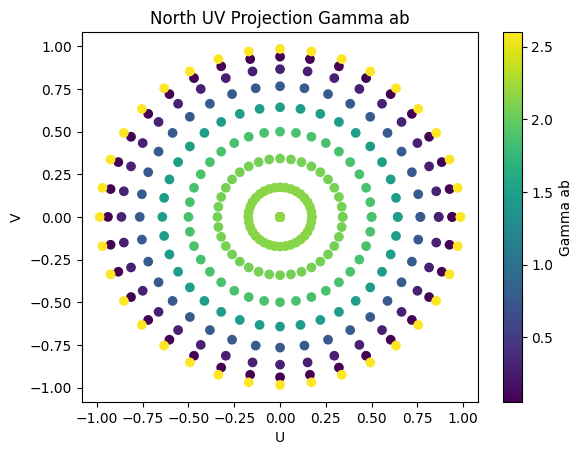

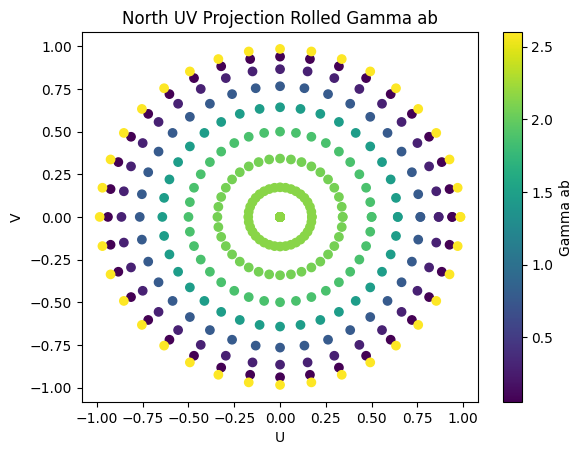

In [48]:
def calc_gamma_ab(
    f, epsilon_i_prime, epsilon_t_prime, 
    sigma, H, bistatic_polarization):
    
    gamma_ab = np.zeros(flat_shape)

    theta_t_values = np.deg2rad(ag.theta.flatten())

    theta_i_values = np.deg2rad(ag.theta_grid.flatten())
    phi_i_values = np.deg2rad(ag.phi_grid.flatten())

    for t in np.arange(twoD_shape[0]):
        theta_t = theta_t_values[t]
        if theta_t < np.pi/2:
            for i in np.arange(flat_shape):
                theta_i = theta_i_values[i]
                phi_i = phi_i_values[i]
                if theta_i < np.pi/2:
                    gamma_ab[i] = np.nan_to_num(transmissivity_fBm(
                            f = f, # Hz
                            epsilon_i_prime = epsilon_i_prime,
                            epsilon_t_prime = epsilon_t_prime,
                            sigma_A = sigma,
                            H = H,
                            theta_i = theta_i,
                            phi_t = phi_i,
                            theta_t = np.pi - theta_t,
                            bistatic_polarization= bistatic_polarization
                        ))
    # Sum all the gamma_abs along the phi axis
    temp = np.sum(gamma_ab.reshape(twoD_shape), -1)
    # Copy the theta axis only pattern back into a circle
    gamma_ab = np.repeat(temp, twoD_shape[-1])
    # Then reflatten gamma_ab for return
    gamma_ab = gamma_ab.flatten()
    return gamma_ab

T_Bv = calc_gamma_ab('vv') * T_Bv * ag.dtheta * ag.dphi + \
    calc_gamma_ab('vh') * T_Bv * ag.dtheta * ag.dphi
T_Bh = calc_gamma_ab('hh') * T_Bh * ag.dtheta * ag.dphi+ \
    calc_gamma_ab('hv') * T_Bh * ag.dtheta * ag.dphi

In [ ]:
gamma_ab = calc_gamma_ab('hh')
# Plot only the Northern Hemisphere of the brightness temperature
U = (np.sin(np.deg2rad(ag.theta_grid[0:9])) * np.cos(np.deg2rad(ag.phi_grid[0:9]))).flatten()
V = (np.sin(np.deg2rad(ag.theta_grid[0:9])) * np.sin(np.deg2rad(ag.phi_grid[0:9]))).flatten()

plt.figure()
plt.scatter(U, V, c=gamma_ab.reshape(twoD_shape)[0:9].flatten()
    , cmap='viridis')
plt.colorbar(label='Gamma ab')
plt.xlabel('U')
plt.ylabel('V')
plt.title('North UV Projection Gamma ab')
plt.show()

In [ ]:
# Integrate the transmitted field by summing to find transmitted field over all incident fields
    # Low band
sigma = sigma_ref * (3e8/5.373e6)**(H)
vertical_bistatic_polarizations = ['vv', 'hv']
horizontal_bistatic_polarizations = ['hh', 'vh']

brightness_field_of_europan_sky_vertical = \
    brightness_field_of_europan_sky_vertical_low_band
brightness_field_of_europan_sky_horizontal = \
    brightness_field_of_europan_sky_horizontal_low_band

brightness_temperature_vertical_low_band = np.zeros_like(ant.theta_grid).flatten()
brightness_temperature_horizontal_low_band = np.zeros_like(ant.theta_grid).flatten()

theta_t_values = ant.theta_grid.flatten()
phi_t_values = ant.phi_grid.flatten()

theta_i_values = ant.theta_grid.flatten()
phi_i_values = ant.phi_grid.flatten()

dtheta = np.deg2rad(10)
dphi = np.deg2rad(10)

for t in np.arange(ant.HF_directivity_pattern_RHCP.size):
    theta_t = theta_t_values[t]
    phi_t = phi_t_values[t]

    for i in np.arange(ant.HF_directivity_pattern_RHCP.size):
        theta_i = theta_i_values[i]
        phi_i = phi_i_values[i]
        
        if theta_t < np.pi/2 and theta_i < np.pi/2:
            gamma_vv = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='vv'
                ))

            gamma_vh = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='vh'
                ))
            
            gamma_hh = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='hh'
                ))            

            gamma_hv = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='hv'
                ))


            brightness_temperature_vertical_low_band[t] += gamma_vv * brightness_field_of_europan_sky_vertical[i] * dtheta * dphi + \
                gamma_vh * brightness_field_of_europan_sky_horizontal[i] * dtheta * dphi
            brightness_temperature_horizontal_low_band[t] += gamma_hh * brightness_field_of_europan_sky_horizontal[i] * dtheta * dphi+ \
                gamma_hv * brightness_field_of_europan_sky_vertical[i] * dtheta * dphi

brightness_temperature_vertical_low_band = np.sin(ant.theta_grid.flatten()) * brightness_temperature_vertical_low_band / (4 * np.pi)
brightness_temperature_vertical_low_band = brightness_temperature_vertical_low_band.reshape(ant.theta_grid.shape)

brightness_temperature_horizontal_low_band = np.sin(ant.theta_grid.flatten()) * brightness_temperature_horizontal_low_band / (4 * np.pi)
brightness_temperature_horizontal_low_band = brightness_temperature_horizontal_low_band.reshape(ant.theta_grid.shape)